# Analyze your Wordpress comments with machine learning x OVHcloud


Launch directly this notebook live via this button : [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/baaastijn/notebooks/master?filepath=machine-learning%2Fwordpress-analyze-sentiments.ipynb)

In this tutorial we will analyze a fake sample of Wordpress comments.

The goal behind is to understand the feedbacks from your customers.

Having a positive and negative score by article, blog post or product can be really useful!


**Requirements :** 
- We will use **OVHcloud Serving Engine**, a (currently free !) tool to deploy machine learning models : https://docs.ovh.com/gb/en/serving-engine/deploy-preset-models/
- that's all folks !


## #1 : import specific Python Libraries

To manipulate data, we will use the famous library Pandas
To do some cURL calls easily, we will use Request and Json libraries

In [2]:
import pandas as pd
import requests
import json

## #2 : export your Wordpress, Drupal,.... comments in CSV

I used a free Wordpress plugin to export my comments directly in CSV.
Plugin page : https://wordpress.org/plugins/comments-import-export-woocommerce/ 

Note that this kind of tutorial will work with other CMS such as Drupal, Magento, ... All you need is a text file with comments !

## #3 : load your Wordpress commments 

Once you have a CSV file, we can now load it in this notebook.

On my case i push it online and i will perform a simple download.
The CSV file will be saved in my environment, it will appear in the left menu of your jupyter notebook.

In [3]:
!wget https://github.com/baaastijn/notebooks/blob/master/machine-learning/wordpress.comments.sample.FR.csv

--2020-03-03 11:03:12--  https://plik.root.gg/file/5TNAB3JwoGnteTxv/6G02ztpgYGH77ihT/wordpress.comments.sample.FR.csv
Resolving plik.root.gg (plik.root.gg)... 164.132.219.248
Connecting to plik.root.gg (plik.root.gg)|164.132.219.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3459 (3.4K) [text/plain]
Saving to: ‘wordpress.comments.sample.FR.csv.1’

wordpress.comments. 100%[===================>]   3.38K  --.-KB/s    in 0s      

2020-03-03 11:03:12 (546 MB/s) - ‘wordpress.comments.sample.FR.csv.1’ saved [3459/3459]



Once downloaded, the command below will read the CSV (using the "," delimiter) and show a sample of 5 record.

Verify that everything is ok. 

**Note that each line, contains an Author of, but also a related "comment_post_ID".**


We will use this information ater to regroup comments by post.


In [6]:
comments = pd.read_csv('wordpress.comments.sample.FR.csv', delimiter = ',')

comments.sample(5)

,comment_ID,comment_post_ID,comment_author,comment_date,comment_content
0,1,1,Karen,2020-02-12 17:47:14,"bof, j'ai pas appris grand chose"
17,18,13,Matthieu,2020-02-16 15:26:11,vous en pensez quoi vous ??
2,3,40,Jacques,2020-02-16 15:26:11,au début j'ai pas aimé mais à la fin c'était t...
3,4,20,Jacques,2020-02-16 15:16:11,nul !!!
34,35,1,Anita,2020-02-16 15:16:11,"trop bidon, à fuir."


## #4 : analyze the comments with OVHcloud Serving engine

Your comments are now ready to be analyzed.

Our goal, is to retrieve per comment, a "positivity" score and a "negativity" score.

Basically, it's a number between 0 and 1. the more you have, the more it is.

Example : "This is awesome !" will have a positivity score like 0.99 and a negativity score near 0.01.


We start first by declaring 2 Dataframes, who will store the scores :

In [7]:
scoreNegativity = []
scorePositivity = []

### Main loop

Here, we perform cURL calls to the OVHcloud Serving Engine API you deployed.

You need to deploy yourself the "Sentiment" model from our catalog, and generate a token

It takes 2 minutes and it's free, just follow the guides here : https://docs.ovh.com/gb/en/serving-engine/deploy-preset-models/

The loop below is quite basic : fore each line in your CSV file, i call the API, and get back an answer.
    
We store this answer in the 2 previously created Dataframes.

**It's a basic tutorial here. For production, we recommend to group your calls. For example, 1 cURL call for 10 lines to analyze.**

In [8]:
url = "put-your-Sentiment-API-endpoint-here----generated-in-OVHcloud-control-panel---example:https://mymodel.serving.ai.ovh.net/my-sentiment/eval"

headers = {
  'accept': "application/json",
  'content-type': "application/json"
}

token = ('token', 'put-your-token-here----generated-in-OVHcloud-control-panel')

for comment in comments.comment_content:
    payload = {'text': comment}
    
    response = requests.request("POST", url, data=json.dumps(payload), headers=headers, auth=token)

    score = json.loads(response.text)
    
    print(f'comment = {comment} // {score}')
    
    scoreNegativity.append(score['negativity'])
    scorePositivity.append(score['positivity'])

comment = bof, j'ai pas appris grand chose // {'negativity': 0.982554018497467, 'positivity': 0.017445974051952362}
comment =  Trés intéressant ! Merci pour le partage :) // {'negativity': 0.0033935178071260452, 'positivity': 0.9966064691543579}
comment = au début j'ai pas aimé mais à la fin c'était très bien // {'negativity': 0.04140491783618927, 'positivity': 0.9585950970649719}
comment = nul !!! // {'negativity': 0.9908764958381653, 'positivity': 0.009123428724706173}
comment = Très étrange. je ne sais pas trop dire si c'était cool ou pas. // {'negativity': 0.5839555263519287, 'positivity': 0.4160445034503937}
comment = :-) // {'negativity': 0.029890984296798706, 'positivity': 0.9701089859008789}
comment = J'ai rien compris. // {'negativity': 0.0869811400771141, 'positivity': 0.9130188226699829}
comment = J'ai acheté ce produit il y a 1 mois il est déja cassé ! // {'negativity': 0.9904404878616333, 'positivity': 0.00955946184694767}
comment = Superbe j'adore // {'negativity': 0.0023

## #5 : add the sentiment analysis results in your Dataframe

Our dataframe contains some columns, as seen before. Let's add 2 new colums to it : negativity score and positivity score :

In [9]:
comments['negativity'] = scoreNegativity
comments['positivity'] = scorePositivity

As a result, your dataframe should now have 2 more columns. Cool ! Let's have a look :

In [10]:
comments

,comment_ID,comment_post_ID,comment_author,comment_date,comment_content,negativity,positivity
0,1,1,Karen,2020-02-12 17:47:14,"bof, j'ai pas appris grand chose",0.982554,0.017446
1,2,5,Joe,2020-02-26 15:26:11,Trés intéressant ! Merci pour le partage :),0.003394,0.996606
2,3,40,Jacques,2020-02-16 15:26:11,au début j'ai pas aimé mais à la fin c'était t...,0.041405,0.958595
3,4,20,Jacques,2020-02-16 15:16:11,nul !!!,0.990876,0.009123
4,5,1,Anita,2020-02-16 15:16:11,Très étrange. je ne sais pas trop dire si c'ét...,0.583956,0.416045
5,6,1,Karen,2020-02-12 17:47:14,:-),0.029891,0.970109
6,7,40,Bastien,2020-02-26 15:26:11,J'ai rien compris.,0.086981,0.913019
7,8,20,Julien,2020-02-16 15:26:11,J'ai acheté ce produit il y a 1 mois il est dé...,0.990440,0.009559
8,9,40,Erika,2020-02-16 15:16:11,Superbe j'adore,0.002370,0.997630
9,10,1,Wilfried,2020-02-16 15:16:11,ben bof voila g rien apri g perdu mon tps,0.021043,0.978957


## #6 visualize your results

Pandas library includes natively visualization tools.
First we can perform a simple graph, representing line by line the results :

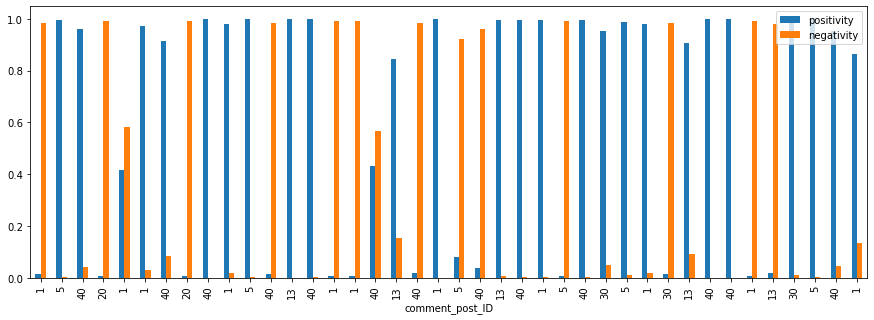

In [17]:
comments.plot(x ='comment_post_ID', y=['positivity','negativity'], kind = 'bar', figsize=(15,5))

Hum, quite hard to read! To gain clarity, we should group lines per related Wordpress articles (it's called "posts" in Wordpress).

You can group your Dataframe with this command below.
                                                                           
Your Dataframe is now composed of an index, "comment_post_ID", and 2 columns, "negativity" and "positivity" 

In [12]:
commentsGrouped = comments.groupby('comment_post_ID').mean()[['negativity','positivity']]
print(commentsGrouped)

                 negativity  positivity
comment_post_ID                        
1                  0.431885    0.568115
5                  0.322109    0.677891
13                 0.247350    0.752650
20                 0.990658    0.009341
30                 0.347996    0.652004
40                 0.283710    0.716290


Let's graph again the results, now grouped by article :

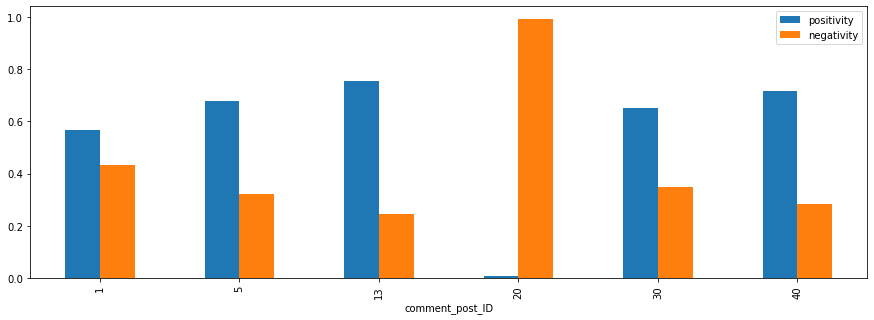

In [16]:
commentsGrouped.plot(y=['positivity','negativity'], kind = 'bar', figsize=(15,5))

## #7 : all done!

Congrats ! We are now able to get positive and negative scores for all our Wordpress Articles, or Products, in fact for whatever we want.

Here it's a basic example, it can be improved for example by downloading the Wordpress data with post_ID and post_names. This way instead of numbers, you will have posts names showed in the graphs.


### Going further... ###

You can go further to perform the same with all the tweets mentionning your Brand for example !

Or all the reviews you have in thrid-party website such as TripAdvisor, Yelp, ...


OVHcloud Serving Engine is able to deploys tons of other models. Built on your own, or pre-trained by OVHcloud.

This tool will also help you to auto-scale, monitor and manage your models versions. Documentation here : https://docs.ovh.com/gb/en/serving-engine/



Have a good day !

Bastien / https://twitter.com/bastienovh/ 